# 1. Crystal Ball

### a.
The integration over a normalized probability must equal unity.

The normalization factor \( N \) is determined by the following condition:

$$
N \cdot \left( \int_{-\beta}^\infty e^{-\frac{Z^2}{2}} \, dZ + \int_0^{-\beta} \left( \frac{m}{\beta} \right)^m e^{-\frac{\beta^2}{2}} \left( \frac{m}{\beta} - \beta - Z \right)^{-m} \, dZ \right)\cdot \frac{dX}{dZ} = 1
$$

---

### Evaluate the first integral

The first integral is:

$$
\int_{-\beta}^\infty e^{-\frac{Z^2}{2}} \, dZ
$$

The cumulative density function of the standard normal distribution is defined as:

$$
\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-\frac{t^2}{2}} \, dt
$$

From this, the tail probability (i.e., the integral from \(x\) to \(\infty\)) is:

$$
\int_x^\infty e^{-\frac{Z^2}{2}} \, dZ = \sqrt{2\pi} \cdot (1 - \Phi(x))
$$

Therefore, the first integral can be written as:

$$
\int_{-\beta}^\infty e^{-\frac{Z^2}{2}} \, dZ = \sqrt{2\pi} \cdot (1 - \Phi(-\beta))
$$

Using the symmetry of gaussian distribution, it is then rewritten as,
$$ \sqrt{2\pi} \cdot (1 - \Phi(-\beta)) = \sqrt{2\pi} \Phi(\beta) $$


---

### Evaluate the second integral

The second integral is:

$$
\int_0^{-\beta} \left( \frac{m}{\beta} \right)^m e^{-\frac{\beta^2}{2}} \left( \frac{m}{\beta} - \beta - Z \right)^{-m} \, dZ
$$

#### Variable substitution:

Let:
$$
a = \frac{m}{\beta} - \beta - Z
$$

Then:
$$
\frac{dZ}{da} = -1
$$


When $ Z = -\beta $, $ a = \frac{m}{\beta} $.

When $ Z = 0 $, $ a = 0 $.

Substituting, the integral becomes:

$$
-\left( \frac{m}{\beta} \right)^m e^{-\frac{\beta^2}{2}} \int_0^{\frac{m}{\beta}} a^{-m} \, da
$$
.
After performing the integration for the second term:

$$
\int_0^{\frac{m}{\beta}} a^{-m} \, da
$$

The result simplifies to:

$$
\frac{a^{-(m-1)}}{-(m-1)} \Bigg|_0^{\frac{m}{\beta}}
$$

Evaluating this expression:

$$
-\frac{\left(\frac{m}{\beta}\right)^{-(m-1)}}{m-1} = \frac{m / \beta}{m - 1}
$$

Thus, the second term becomes:

$$
\frac{m / \beta}{m - 1} e^{-\beta^2 / 2}
$$


---

The total normalization condition is then:

$$
 N (\sqrt{2\pi} \Phi(\beta) + \frac{m / \beta}{m - 1} e^{-\beta^2 / 2})\sigma = 1
$$




### b.
f(x, y) = f*s(x, y) + (1-f)*n(x, y)
= f*g_s(x)*h_s(y) L (1-f)*g_b(x)*h_b(y)
g_s =  crystal ball function
h_s = lambda*exp(-lambda*y)
g_b = uniform random noise
h_b = 1/sigma/sqrt(2*pi)*exp(-1/2*(x-mu)/(sigma**2))
where X is in range of [0, 5] and Y is in range of [0, 10].




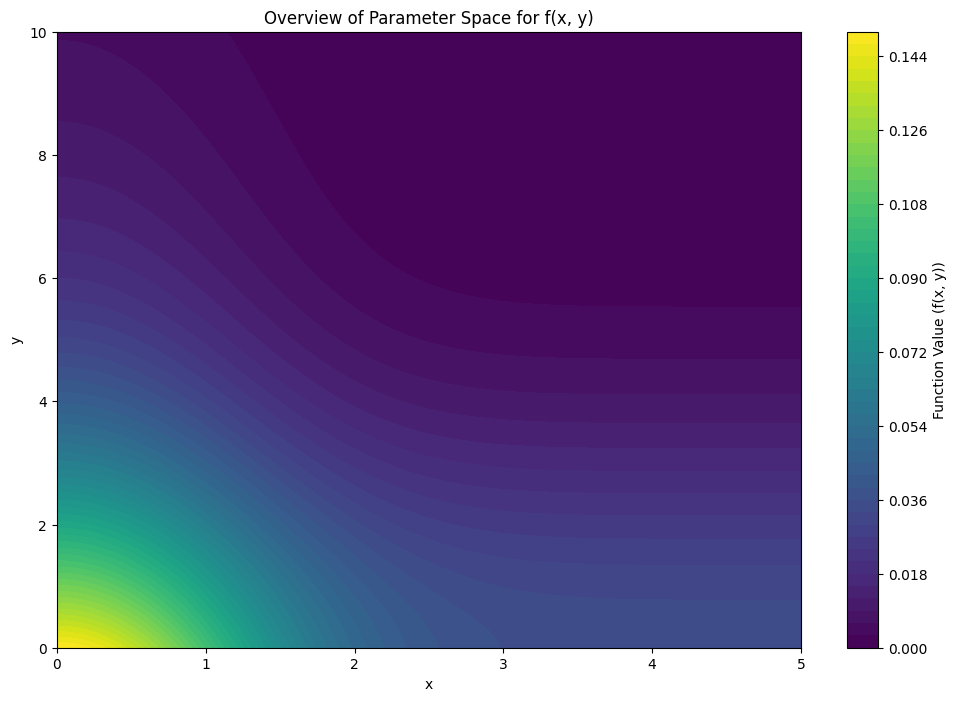

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import crystalball, uniform, norm, expon
from scipy.integrate import dblquad


class Function:
    """Base class to hold parameters and shared methods."""
    # Global parameter store
    global_params = {
        "beta": 1.0,
        "m": 1.4,
        "lambda_param": 0.3,
        "mub": 0,
        "sigmab": 2.5,
        "mu": 3,
        "sigma": 0.3,
        "f": 0.6,
    }

    def __init__(self):
        # Instance parameters initialized from global parameters
        for key, value in self.global_params.items():
            setattr(self, key, value)
        self.func = None  # Placeholder for specific function

    @classmethod
    def update_global_params(cls, **kwargs):
        """Update global parameters and propagate changes to all instances."""
        for key, value in kwargs.items():
            if key in cls.global_params:
                cls.global_params[key] = value
            else:
                raise AttributeError(f"Parameter {key} does not exist.")
        cls._propagate_updates()

    @classmethod
    def _propagate_updates(cls):
        """Optional method for subclasses to update their functions."""
        pass

    def __call__(self, *args, **kwargs):
        """Evaluate the function."""
        if self.func is None:
            raise NotImplementedError("The specific function is not defined.")
        return self.func(*args, **kwargs)


class g_s(Function):
    def __init__(self):
        super().__init__()
        self.update_function()

    def update_function(self):
        """Update the Crystal Ball function based on current parameters."""
        self.func = lambda x: crystalball.pdf(x, beta=self.beta, m=self.m)

    @classmethod
    def _propagate_updates(cls):
        """Propagate updates to all instances."""
        for instance in cls.instances:
            instance.update_function()


class h_s(Function):
    def __init__(self):
        super().__init__()
        self.update_function()

    def update_function(self):
        """Update the Exponential function based on current parameters."""
        self.func = lambda y: expon.pdf(y, scale=1 / self.lambda_param)

    @classmethod
    def _propagate_updates(cls):
        """Propagate updates to all instances."""
        for instance in cls.instances:
            instance.update_function()


class g_b(Function):
    def __init__(self):
        super().__init__()
        self.func = lambda x: uniform.pdf(x, loc=0, scale=5)


class h_b(Function):
    def __init__(self):
        super().__init__()
        self.update_function()

    def update_function(self):
        """Update the Gaussian function based on current parameters."""
        self.func = lambda y: norm.pdf(y, loc=self.mub, scale=self.sigmab)

    @classmethod
    def _propagate_updates(cls):
        """Propagate updates to all instances."""
        for instance in cls.instances:
            instance.update_function()


def overall_function(x, y):
    """Combine signal and noise components into the overall function."""
    gs = g_s()
    hs = h_s()
    gb = g_b()
    hb = h_b()

    f = gs.f  # Signal-to-noise ratio
    return f * gs(x) * hs(y) + (1 - f) * gb(x) * hb(y)


# Visualization of Parameter Space
x_min, x_max = 0, 5
y_min, y_max = 0, 10
x_vals = np.linspace(x_min, x_max, 100)
y_vals = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Normalize the function
Z = overall_function(X, Y)
N, _ = dblquad(
    lambda y, x: overall_function(x, y), x_min, x_max, lambda x: y_min, lambda x: y_max
)

plt.figure(figsize=(12, 8))
contour = plt.contourf(X, Y, Z / N, levels=50, cmap='viridis')
plt.colorbar(contour, label="Function Value (f(x, y))")
plt.title("Overview of Parameter Space for f(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Updating global parameters for the problem step (d).
Function.update_global_params(mub=1.0, sigmab=1.5, f=0.7)
Z_updated = overall_function(X, Y)


### C.

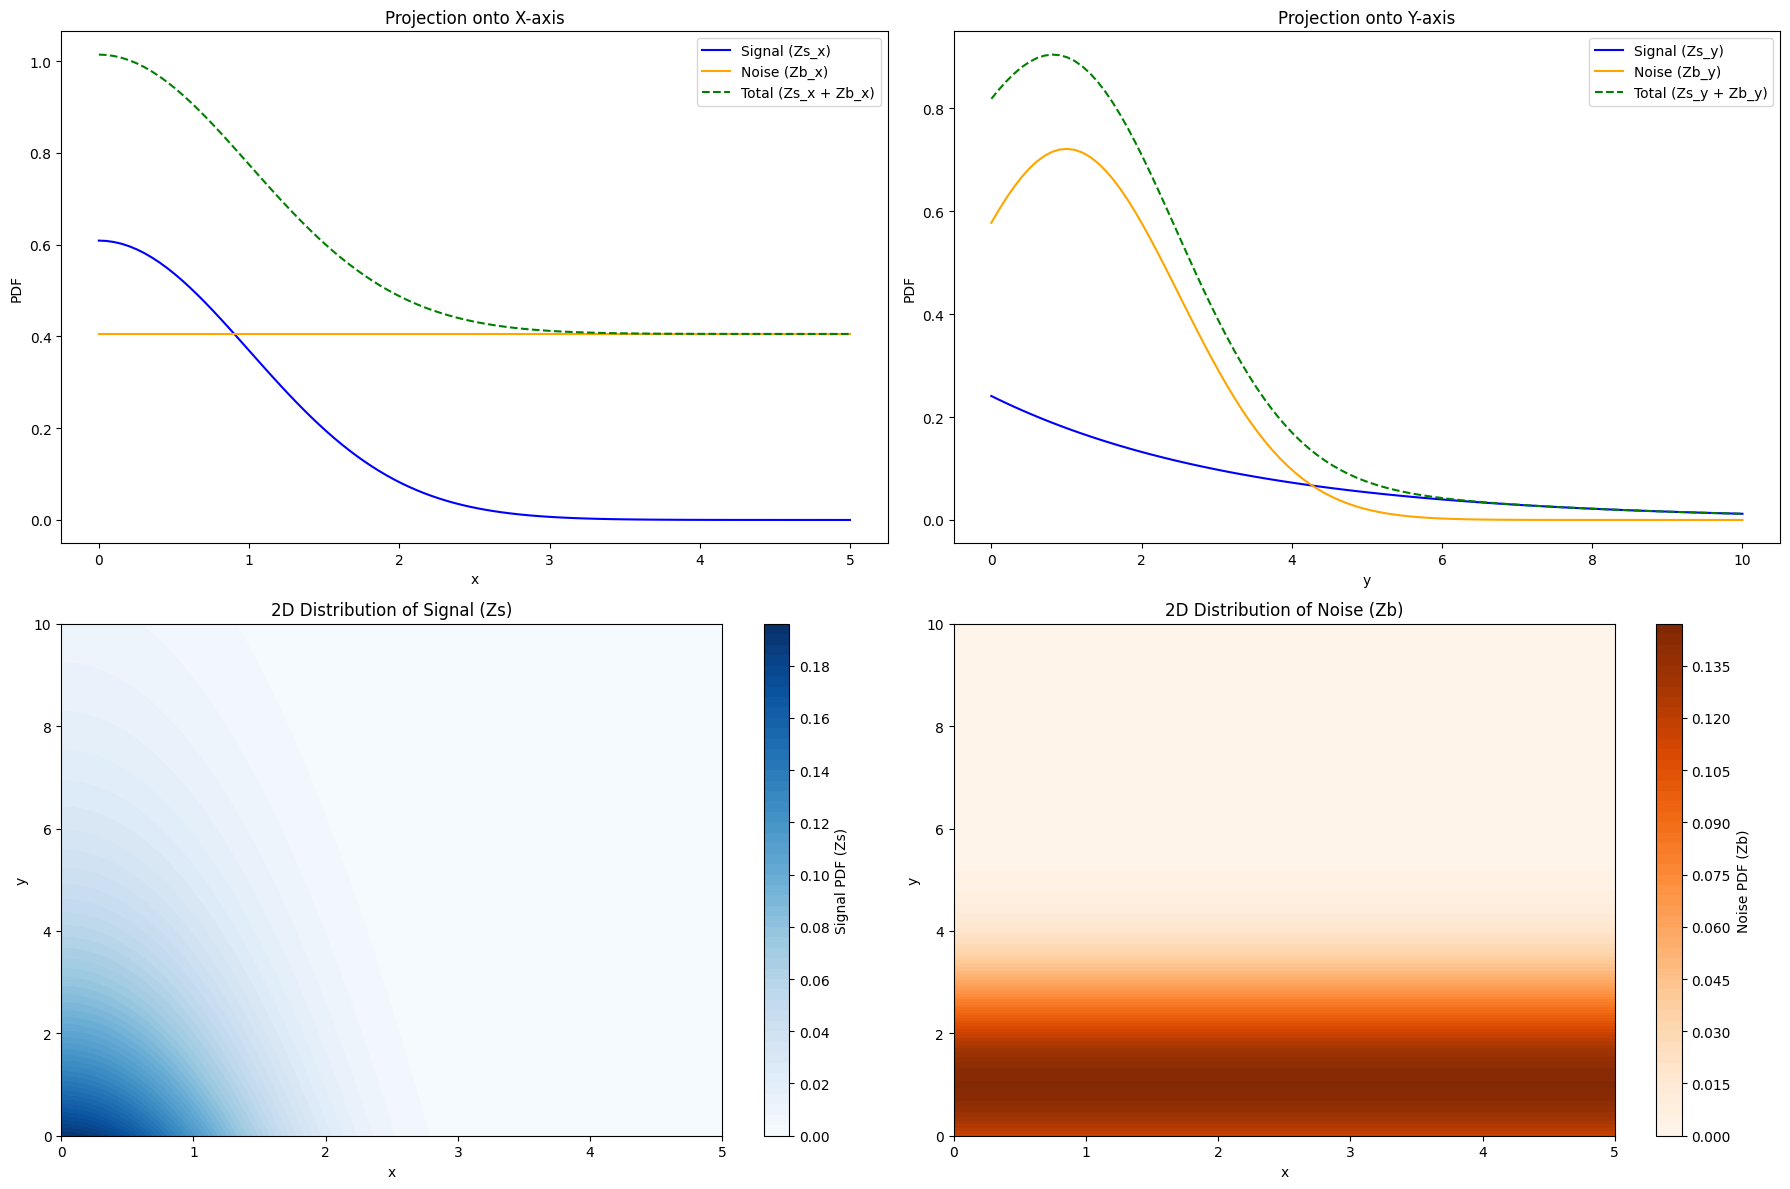

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

def signal_function(x, y):
    gs = g_s()
    hs = h_s()
    return gs(x) * hs(y)


def noise_function(x, y):
    gb = g_b()
    hb = h_b()
    return gb(x) * hb(y)


# Compute integrations
marginal_signal_x = np.array([quad(lambda y: signal_function(x, y), y_min, y_max)[0] / N for x in x_vals])
marginal_noise_x = np.array([quad(lambda y: noise_function(x, y), y_min, y_max)[0] / N for x in x_vals])

marginal_signal_y = np.array([quad(lambda x: signal_function(x, y), x_min, x_max)[0] / N for y in y_vals])
marginal_noise_y = np.array([quad(lambda x: noise_function(x, y), x_min, x_max)[0] / N for y in y_vals])

# Compute total marginals
total_marginal_x = marginal_signal_x + marginal_noise_x
total_marginal_y = marginal_signal_y + marginal_noise_y

x_vals = np.linspace(x_min, x_max, 100)
y_vals = np.linspace(y_min, y_max, 100)

# Evaluate 2D distributions
X, Y = np.meshgrid(x_vals, y_vals)
Zs = np.vectorize(signal_function)(X, Y) / N
Zb = np.vectorize(noise_function)(X, Y) / N

# Plot projections and 2D distributions
plt.figure(figsize=(18, 12))

# Projection onto x-axis
plt.subplot(2, 2, 1)
plt.plot(x_vals, marginal_signal_x, label="Signal (Zs_x)", color="blue")
plt.plot(x_vals, marginal_noise_x, label="Noise (Zb_x)", color="orange")
plt.plot(x_vals, total_marginal_x, label="Total (Zs_x + Zb_x)", color="green", linestyle="--")
plt.title("Projection onto X-axis")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()

# Projection onto y-axis
plt.subplot(2, 2, 2)
plt.plot(y_vals, marginal_signal_y, label="Signal (Zs_y)", color="blue")
plt.plot(y_vals, marginal_noise_y, label="Noise (Zb_y)", color="orange")
plt.plot(y_vals, total_marginal_y, label="Total (Zs_y + Zb_y)", color="green", linestyle="--")
plt.title("Projection onto Y-axis")
plt.xlabel("y")
plt.ylabel("PDF")
plt.legend()

# 2D distribution for signal
plt.subplot(2, 2, 3)
contour_signal = plt.contourf(X, Y, Zs, levels=50, cmap="Blues")
plt.colorbar(contour_signal, label="Signal PDF (Zs)")
plt.title("2D Distribution of Signal (Zs)")
plt.xlabel("x")
plt.ylabel("y")

# 2D distribution for noise
plt.subplot(2, 2, 4)
contour_noise = plt.contourf(X, Y, Zb, levels=50, cmap="Oranges")
plt.colorbar(contour_noise, label="Noise PDF (Zb)")
plt.title("2D Distribution of Noise (Zb)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

-------------------------------------
1.17 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-------------------------------------
437 ms ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


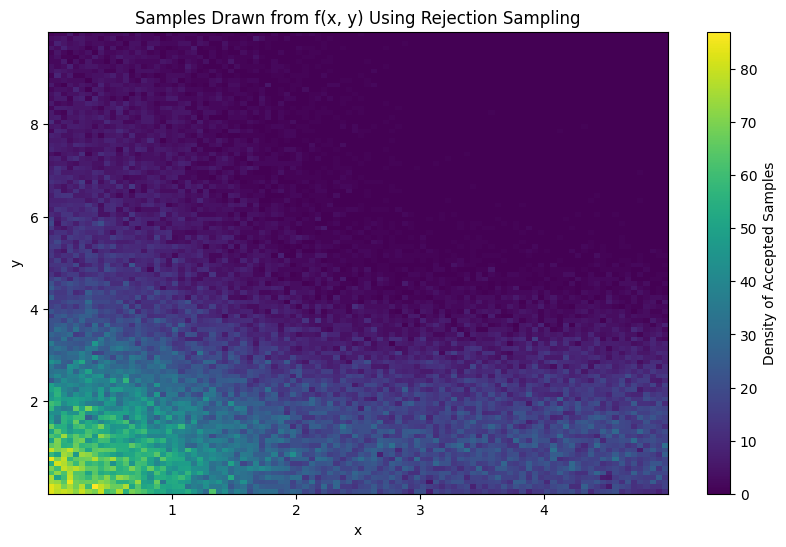

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

print("-------------------------------------")
%timeit np.random.uniform(0, 1, size=int(1e5))
print("-------------------------------------")

# Updated Rejection Sampling Function
def generate_samples(num_samples):
    x_min, x_max = 0, 5
    y_min, y_max = 0, 10
    z_max = 0.17  # Maximum of the normalized function from earlier computations

    np.random.seed(42)

    accepted_X, accepted_Y = [], []

    while len(accepted_X) < num_samples:
        # Generate a batch of random numbers
        batch_size = int(num_samples * 1.5)  # Generate a larger batch to minimize iterations
        X = np.random.uniform(x_min, x_max, size=batch_size)
        Y = np.random.uniform(y_min, y_max, size=batch_size)
        Z = np.random.uniform(0, z_max, size=batch_size)

        # Evaluate the function
        f_values = overall_function(X, Y)

        # Accept samples where Z < f(x, y)
        mask = Z < f_values
        accepted_X.extend(X[mask])
        accepted_Y.extend(Y[mask])

    # Trim to the desired number of samples
    return np.array(accepted_X[:num_samples]), np.array(accepted_Y[:num_samples])

# Generate samples
num_samples = int(1e5)  # Desired number of accepted samples
%timeit x_data, y_data = generate_samples(num_samples)
x_data, y_data = generate_samples(num_samples)

# Plot the accepted samples
plt.figure(figsize=(10, 6))
plt.hist2d(x_data, y_data, bins=100, cmap='viridis')
plt.colorbar(label='Density of Accepted Samples')
plt.title('Samples Drawn from f(x, y) Using Rejection Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Rationale

Looking at the generated sample data, it is evident that there are two overlapping distributions:
- **Signal Distribution**: Concentrated in the bottom-left region of the sample space.
- **Background Distribution**: Uniformly distributed and dependent only on y.

Since the overall distribution is given as a combination of these two separate components, it is natural to isolate the **background (noise-only) distribution** by focusing on data that is not significantly affected by the signal.

### Approach

To achieve this, the parameter estimation is performed in two steps:
1. **Noise Estimation**:
   - Use data where \( x > 2 \), a region where the signal has minimal influence, to estimate the parameters of the noise distribution.
2. **Signal Estimation**:
   - After fixing the noise parameters from step 1, estimate the signal distribution using all available data.


Optimization Successful!
Estimated mub: 9.467391933660875e-08
Estimated sigmab: 2.127343039851031


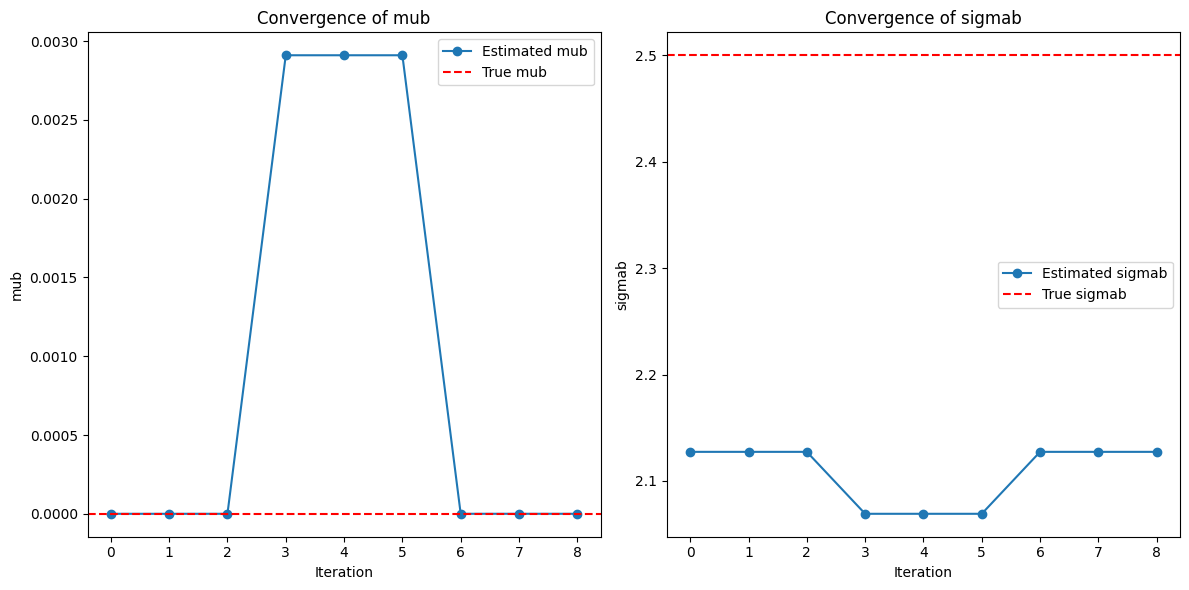

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

# Filter x_data and y_data based on x > 2
mask = x_data > 2
filtered_x_data = x_data[mask]
filtered_y_data = y_data[mask]

# Mirror y_data for symmetry
mirrored_x_data = np.concatenate([filtered_x_data,  filtered_x_data])
mirrored_y_data = np.concatenate([filtered_y_data, -filtered_y_data])

# Negative log-likelihood for normal distribution
def negative_log_likelihood_normal(params, x_data, y_data, iteration_tracker):
    mub, sigmab = params
    if sigmab <= 0:  # Enforce positivity of sigma_b
        return np.inf

    # Compute the noise_function with the updated parameters
    Function.update_global_params(mub=mub, sigmab=sigmab)
    model = noise_function(x_data, y_data)

    # Compute negative log-likelihood
    nll = -np.sum(np.log(model + 1e-10))  # Avoid log(0) with epsilon

    # Track parameter estimation
    iteration_tracker.append((mub, sigmab, nll))
    return nll

# Initial guesses for parameters
mub_guess = np.mean(mirrored_y_data)
sigmab_guess = np.std(mirrored_y_data)
initial_guess = [mub_guess, sigmab_guess]

# Parameter bounds
bounds = [
    (mub_guess - 2 * sigmab_guess, mub_guess + 2 * sigmab_guess),  # Bounds for mub
    (1e-3, sigmab_guess * 2)  # Bounds for sigmab
]

# Track parameter updates
iteration_tracker = []

# Perform optimization
result = minimize(
    negative_log_likelihood_normal,
    initial_guess,
    args=(mirrored_x_data, mirrored_y_data, iteration_tracker),
    bounds=bounds,
    method="L-BFGS-B"  # ("Nelder-Mead", "Powell", "L-BFGS-B")
)

# Extract estimated parameters
if result.success:
    estimated_mub, estimated_sigmab = result.x
    print("Optimization Successful!")
    print(f"Estimated mub: {estimated_mub}")
    print(f"Estimated sigmab: {estimated_sigmab}")
else:
    print("Optimization failed:", result.message)

# Plot the parameter estimation process
iterations = np.arange(len(iteration_tracker))
mub_values = [item[0] for item in iteration_tracker]
sigmab_values = [item[1] for item in iteration_tracker]
nll_values = [item[2] for item in iteration_tracker]

plt.figure(figsize=(12, 6))

# Plot mub values
plt.subplot(1, 2, 1)
plt.plot(iterations, mub_values, label="Estimated mub", marker='o')
plt.axhline(0.0, color='red', linestyle='--', label="True mub")
plt.xlabel("Iteration")
plt.ylabel("mub")
plt.title("Convergence of mub")
plt.legend()

# Plot sigmab values
plt.subplot(1, 2, 2)
plt.plot(iterations, sigmab_values, label="Estimated sigmab", marker='o')
plt.axhline(2.5, color='red', linestyle='--', label="True sigmab")
plt.xlabel("Iteration")
plt.ylabel("sigmab")
plt.title("Convergence of sigmab")
plt.legend()

plt.tight_layout()
plt.show()


Optimization Successful!
Estimated beta: 0.32769018169656894
Estimated m: 3.0
Estimated lambda_param: 0.5751926945829908
Estimated f: 0.3400607808400908


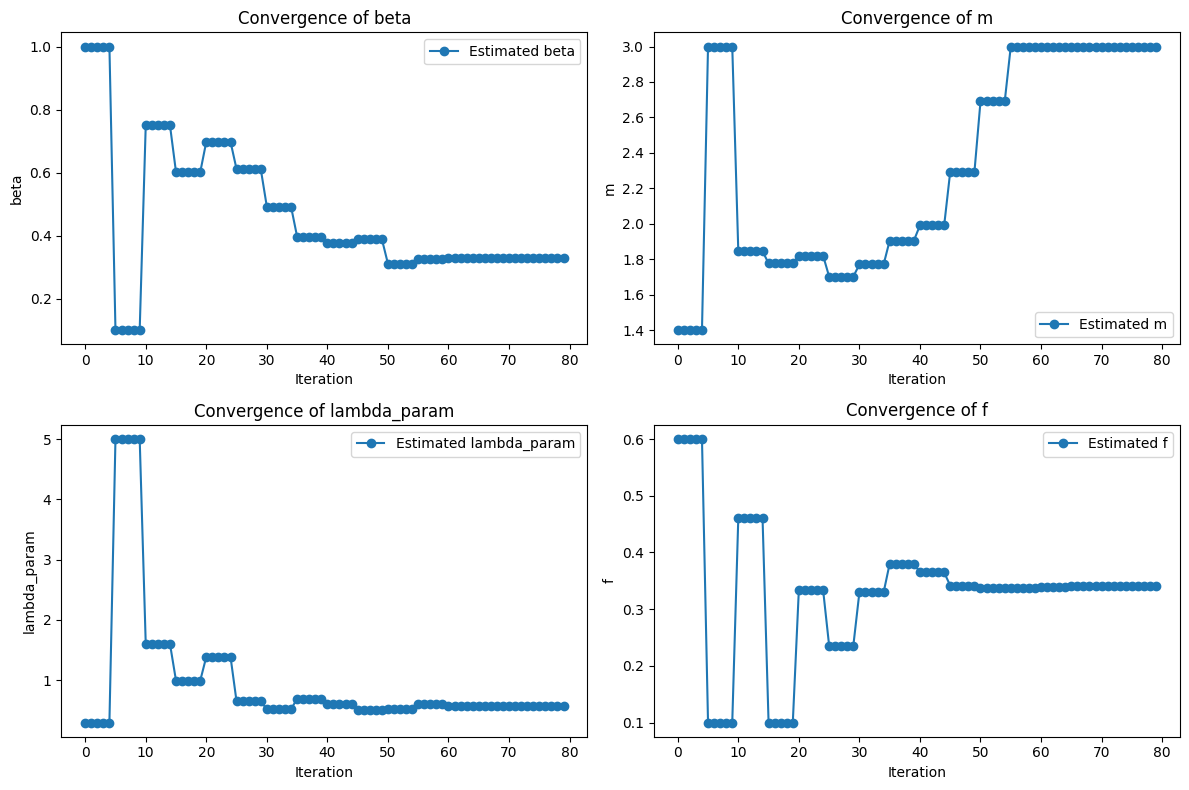

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Assuming `overall_function` and `Function.update_global_params` are defined elsewhere

# Double mirror data for symmetry on both x and y axes
mirrored_x_data = np.concatenate([filtered_x_data, filtered_x_data, -filtered_x_data, -filtered_x_data])
mirrored_y_data = np.concatenate([filtered_y_data, -filtered_y_data, filtered_y_data, -filtered_y_data])

# Negative log-likelihood for overall_function
def negative_log_likelihood_overall(params, x_data, y_data, iteration_tracker):
    beta, m, lambda_param, f = params

    # Update parameters globally
    Function.update_global_params(beta=beta, m=m, lambda_param=lambda_param, f=f)

    # Evaluate the overall function
    model = overall_function(x_data, y_data)

    # Compute negative log-likelihood
    nll = -np.sum(np.log(model + 1e-10))  # Avoid log(0) with a small epsilon

    # Track parameter estimation
    iteration_tracker.append((beta, m, lambda_param, f, nll))
    return nll

# Initial guesses for parameters
beta_guess = 1.0
m_guess = 1.4
lambda_param_guess = 0.3
f_guess = 0.6
initial_guess = [beta_guess, m_guess, lambda_param_guess, f_guess]

# Bounds for the parameters
bounds = [
    (0.1, 5.0),   # 0.1 <= beta <= 5.0
    (0.1, 3.0),   # 0.1 <= m <= 3.0
    (0.1, 5.0),   # 0.1 <= lambda_param <= 5.0
    (0.1, 0.9),   # 0.1 <= f <= 0.9
]

# Fix noise parameters using results from earlier estimation
Function.update_global_params(mub=estimated_mub, sigmab=estimated_sigmab)

# Track parameter updates
iteration_tracker = []

# Perform optimization
result = minimize(
    negative_log_likelihood_overall,
    initial_guess,
    args=(mirrored_x_data, mirrored_y_data, iteration_tracker),
    bounds=bounds,
    method="L-BFGS-B"  # You can experiment with "Nelder-Mead", "Powell", or "L-BFGS-B"
)

# Extract estimated parameters
if result.success:
    estimated_beta, estimated_m, estimated_lambda_param, estimated_f = result.x
    print("Optimization Successful!")
    print(f"Estimated beta: {estimated_beta}")
    print(f"Estimated m: {estimated_m}")
    print(f"Estimated lambda_param: {estimated_lambda_param}")
    print(f"Estimated f: {estimated_f}")
else:
    print("Optimization failed:", result.message)

# Plot the parameter estimation process
iterations = np.arange(len(iteration_tracker))
beta_values = [item[0] for item in iteration_tracker]
m_values = [item[1] for item in iteration_tracker]
lambda_param_values = [item[2] for item in iteration_tracker]
f_values = [item[3] for item in iteration_tracker]
nll_values = [item[4] for item in iteration_tracker]

plt.figure(figsize=(12, 8))

# Plot beta values
plt.subplot(2, 2, 1)
plt.plot(iterations, beta_values, label="Estimated beta", marker='o')
plt.xlabel("Iteration")
plt.ylabel("beta")
plt.title("Convergence of beta")
plt.legend()

# Plot m values
plt.subplot(2, 2, 2)
plt.plot(iterations, m_values, label="Estimated m", marker='o')
plt.xlabel("Iteration")
plt.ylabel("m")
plt.title("Convergence of m")
plt.legend()

# Plot lambda_param values
plt.subplot(2, 2, 3)
plt.plot(iterations, lambda_param_values, label="Estimated lambda_param", marker='o')
plt.xlabel("Iteration")
plt.ylabel("lambda_param")
plt.title("Convergence of lambda_param")
plt.legend()

# Plot f values
plt.subplot(2, 2, 4)
plt.plot(iterations, f_values, label="Estimated f", marker='o')
plt.xlabel("Iteration")
plt.ylabel("f")
plt.title("Convergence of f")
plt.legend()

plt.tight_layout()
plt.show()
